In [1]:
import os
import shutil
import random
#Cargar categorias y dividir el dataset
splitsize = .7
categories = []
source = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/"
folders = os.listdir(source)
if ".DS_Store" in folders:
    os.remove(f"{source}/.DS_store")

for subfolder in folders:
    if os.path.isdir(source + subfolder):
        categories.append(subfolder)
categories.sort()
print(categories)

#Create dataset
target_folder = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset"
existDatasetPath = os.path.exists(target_folder)
if not existDatasetPath:
    os.mkdir(target_folder)

#split data train and test
def split_data(SOURCE, TRAINING, TEST, SPLIT_SIZE):
    files = []

    for filename in os.listdir(SOURCE):
        file = SOURCE + "/" +filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is empty")
    print(len(files))
    print(SPLIT_SIZE)
    trainingLength = round(len(files) * SPLIT_SIZE)
    shuffleSet = random.sample(files, len(files))
    trainingSet = shuffleSet[0:trainingLength]
    testSet = shuffleSet[trainingLength:]

    #copy train images
    for filename in trainingSet:
         thisFile = SOURCE + filename
         destination = TRAINING + filename
         shutil.copyfile(thisFile, destination)
    
    #copy test images
    for filename in testSet:
        thisFile = SOURCE + filename
        destination = TEST + filename
        shutil.copyfile(thisFile, destination)

trainPath = target_folder + "/train"
testPath = target_folder + "/test"

#create target folders
existTrainPath = os.path.exists(trainPath)
if not existTrainPath:
    os.mkdir(trainPath)

existTestPath = os.path.exists(testPath)
if not existTestPath:
    os.mkdir(testPath)

for category in categories:
    trainDestPath = trainPath + "/" + category
    testDestPath = testPath + "/" + category

    if not os.path.exists(trainDestPath):
        os.mkdir(trainDestPath)
    if not os.path.exists(testDestPath):
        os.mkdir(testDestPath)

    sourcePath = source + category + "/"
    trainDestPath = trainDestPath + "/" 
    testDestPath = testDestPath + "/"

    print("Copy from: " + sourcePath + " to: " + trainDestPath + " " + testDestPath)
    split_data(sourcePath, trainDestPath, testDestPath, splitsize)
    

['cyclocephala_lunulata', 'dysdercus_concinnus', 'leptinotarsa_decemlineata']
Copy from: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/ to: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/train/cyclocephala_lunulata/ /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/test/cyclocephala_lunulata/
157
0.7
Copy from: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/ to: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/train/dysdercus_concinnus/ /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/test/dysdercus_concinnus/
167
0.7
Copy from: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/ to: /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/train/leptinotarsa_decemlineata/ /Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/test/leptinotarsa_decem

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

trainPath = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/train"
testPath = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/dataset/test"

# Generate more images
trainGenerator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.4,
    height_shift_range=0.1,
    brightness_range=(0, 0.2)
).flow_from_directory(trainPath, target_size=(320, 320), batch_size=32)
testGenerator = ImageDataGenerator(
    rotation_range=15, 
    width_shift_range=0.4, 
    height_shift_range=0.1, 
    brightness_range=(
    0, 0.2)
).flow_from_directory(testPath, target_size=(320, 320), batch_size=32)

# Build model

baseModel = EfficientNetB0(weights="imagenet", include_top=False)
x = baseModel.output
x = GlobalAveragePooling2D()(x)  # 1
x = Dense(512, activation="relu")(x)  # 2
x = Dense(256, activation="relu")(x)  # 3
x = Dense(128, activation="relu")(x)  # 4

predictionLayer = Dense(len(categories), activation="softmax")(x)  # 5

model = Model(inputs=baseModel.input, outputs=predictionLayer)

# Congelar todas las capas del modelo menos las 5 añadidas por nosotros
# Deja fijos los pesos de EfficientNet-B0 pero permite modificar los pesos de las capas que creamos
for layer in model.layers[:-5]:
    layer.trainable = False

# Compilar modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer, metrics=['accuracy'])

# Entrenar modelo
modelTrainData = model.fit(
    trainGenerator, validation_data=testGenerator, epochs=10)

# Guardar modelo
saveModelPath = "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/ModelEfficientNetB0.keras"
model.save(saveModelPath)

plt.figure()
plt.subplot(211)
plt.plot(modelTrainData.history['accuracy'])
plt.subplot(212)
plt.plot(modelTrainData.history['loss'])

Found 483 images belonging to 3 classes.
Found 270 images belonging to 3 classes.


c:\Users\santi\anaconda3\envs\semillero\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


KeyboardInterrupt: 

In [4]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np

#Predict Image
def classify_image(IMG_PATH):
    x=[]
    img = Image.open(IMG_PATH)
    img.load()
    img = img.resize((320,320), Image.LANCZOS)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)
    return pred[0]

In [7]:
img_paths = [
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/cyclocephala_lunulata (34).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/dysdercus_concinnu (65).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/leptinotarsa_decemlineata (98).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/cyclocephala_lunulata (3).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/dysdercus_concinnu (45).jpeg",
    "/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/leptinotarsa_decemlineata (10).jpeg"
]

predictions = []
for path in img_paths:
    print(path)
    predictions.append(classify_image(path))

/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/cyclocephala_lunulata (34).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/dysdercus_concinnu (65).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/leptinotarsa_decemlineata (98).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/cyclocephala_lunulata/cyclocephala_lunulata (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/dysdercus_concinnus/dysdercus_concinnu (45).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
/Users/santi/OneDrive/Desktop/UNIVERSIDAD/Semillero/Proyecto/Insectos/leptinotarsa_decemlineata/leptinotarsa_decemlineata (10).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


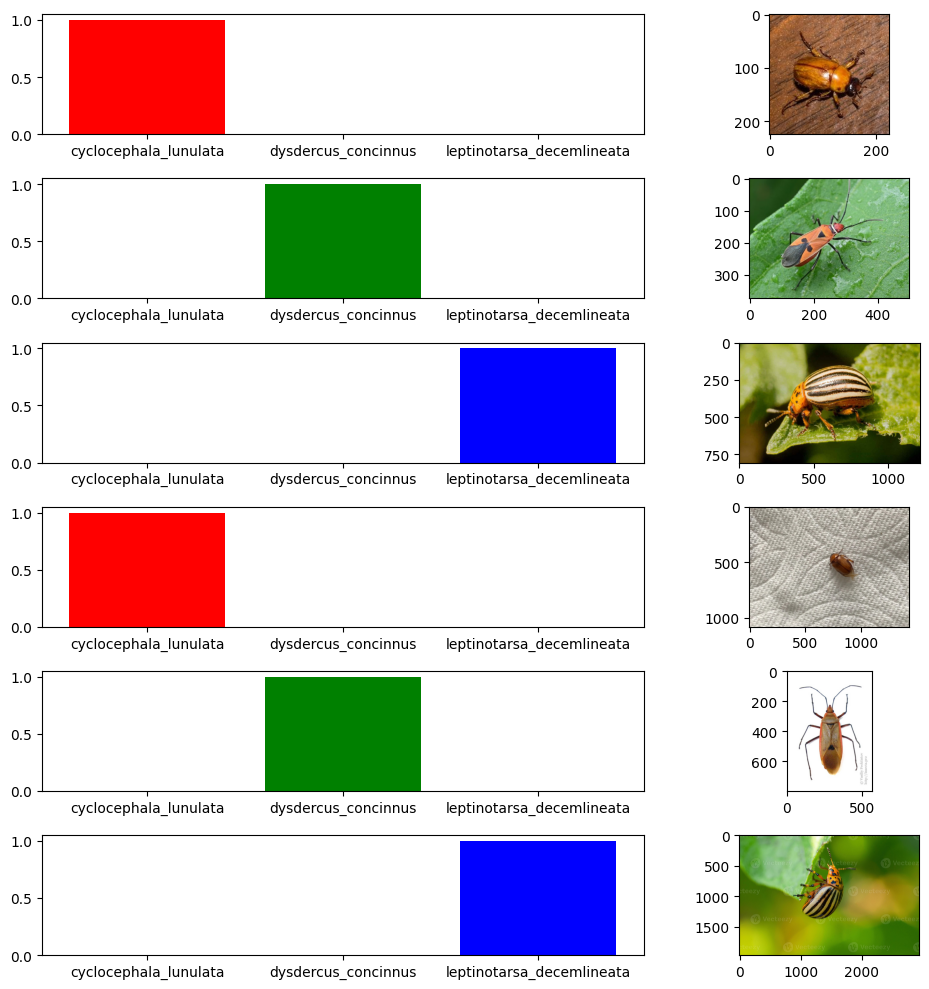

In [8]:
fig,axs = plt.subplots(len(predictions), 2, figsize=(10, 10), gridspec_kw={'width_ratios': [2, 1]})

plotIndex = 1
for i, pred in enumerate(predictions):
    plt.subplot(len(predictions), 2, plotIndex)
    plt.bar(categories, pred, color=['red', 'green', 'blue'])

    plt.subplot(len(predictions), 2, plotIndex+1)
    img = plt.imread(img_paths[i])
    plt.imshow(img)
    plotIndex += 2

fig.tight_layout()
plt.show()